In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
)

In [2]:
go_task_list_values = np.linspace(0, 1, 8)

In [3]:
batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.6,
        positive_shift_delay_time=0.0,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
        value=(0, 1),
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.6, positive_shift_trial_time=0.0, value=0)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm, value=(0, 1))
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.1,
        positive_shift_trial_time=0.8,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.1,
        positive_shift_trial_time=0.8,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(trial_time=0.1, positive_shift_trial_time=0.2),
        delay=0.1,
        positive_shift_delay_time=1.4,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

tasks_sequence = [
    MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        task_number=i,
        mode="value",
    )
    for i in range(len(tasks))
]

In [4]:
dm_task_1_sequence = []
dm_task_values = [0, 0.4, 0.6, 1]
for value in dm_task_values:
    dm_parameters = DMTaskRandomModParameters(
        dm=DMTaskParameters(trial_time=0.6, positive_shift_trial_time=0.0, value=value)
    )
    dm_task_1_sequence.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("DMTask1"),
            mode="value",
        )
    )

In [5]:
tasks_and_names = dict([*zip(sorted(tasks), tasks_sequence)])
chosed_tasks = ["CtxDMTask1", "GoTask1", "GoRtTask1", "GoDlTask1", "RomoTask1"]
chosed_tasks_dict = {}
for key, item in tasks_and_names.items():
    if key in chosed_tasks:
        chosed_tasks_dict[key] = item
print("Tasks for PCA")
print(chosed_tasks_dict)

Tasks for PCA
{'CtxDMTask1': <cgtasknet.tasks.reduce.multy.MultyReduceTasks object at 0x0000024DC5A1A7C0>, 'GoDlTask1': <cgtasknet.tasks.reduce.multy.MultyReduceTasks object at 0x0000024DC59F7280>, 'GoRtTask1': <cgtasknet.tasks.reduce.multy.MultyReduceTasks object at 0x0000024DC59F77F0>, 'GoTask1': <cgtasknet.tasks.reduce.multy.MultyReduceTasks object at 0x0000024DC59F7DC0>, 'RomoTask1': <cgtasknet.tasks.reduce.multy.MultyReduceTasks object at 0x0000024DC59FB130>}


In [6]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 256

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.55),
    tau_ada_inv=torch.as_tensor(1 / 2.0),
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=20,
    save_states=True,
    # return_spiking=False,
).to(device)
model.load_state_dict(
    torch.load(
        r"A:\src\multy_task\models\low_freq\mean_fr_filter_less\weights\weights_100_N_256_without_square_2199_",
        map_location=device,
    )
)

<All keys matched successfully>

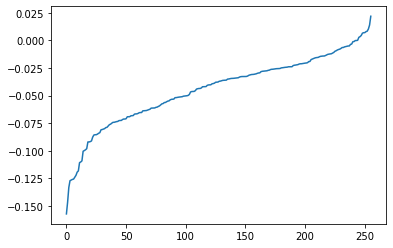

In [7]:
for name, param in model.named_parameters():
    if name == "alif.recurrent_weights":
        final_parameters = torch.clone(param.detach().cpu())
plt.plot(torch.sort(torch.mean(final_parameters, axis=1)).values)

In [8]:
from cgtasknet.instruments.instrument_accuracy_network import CorrectAnswerNetwork

sorted_tasks = sorted(tasks)
re_word = "Go"
choices_tasks = []
values_tasks = []
for i in range(len(sorted_tasks)):
    if re_word in sorted_tasks[i]:
        values_tasks.append(i)
    else:
        choices_tasks.append(i)
can = CorrectAnswerNetwork(choices_tasks, values_tasks, 0.15)
inputs, target_outputs = dm_task_1_sequence[0].dataset(delay_between=0)

inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs = model(inputs)[0]
type_tasks = list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])
answers = can.run(
    target_outputs[50:, :, 0].detach().cpu(),
    outputs[50:, :, 0].detach().cpu(),
    target_outputs[50:, :, 1:].detach().cpu(),
    outputs[50:, :, 1:].detach().cpu(),
    type_tasks,
)
print(answers)

1


In [9]:
from numba import njit, prange


@njit(cache=True, parallel=True)
def every_bath_generator(
    start_sigma: float,
    stop_sigma: float,
    times: int = 1,
    batches: int = 1,
    actions: int = 1,
):
    data = np.zeros((times, batches, actions))
    for i in prange(batches):
        data[:, i, :] = np.random.normal(
            0, np.random.uniform(start_sigma, stop_sigma), size=(times, actions)
        )
    return data

In [10]:
from cgtasknet.instruments.instrument_pca import PCA


def single_task_pca_generate(
    task,
    network,
    added_iterations=1000,
    init_state=None,
    mult_pca=False,
    task_time=False,
):
    if not isinstance(task, list):
        task = [task]
    v, a = [], []
    tasks_time_save = []
    for t in task:
        data, _ = t.dataset(1, delay_between=0)
        added_data = np.zeros((added_iterations, data.shape[1], data.shape[2]))
        find_task_index = np.where(data[-1, 0, 3:] == 1)[0][0]
        # print(find_task_index)
        # added_data[:, :, find_task_index] = 1
        data = np.concatenate((data, added_data))
        data = torch.from_numpy(data).type(torch.float).to(device)
        out, states = network(data, init_state)
        v_t = []
        a_t = []
        for j in range(len(states)):
            v_t.append(states[j].v)
            a_t.append(states[j].a)
        v_t = torch.concat(v_t).detach()
        a_t = torch.concat(a_t).detach()
        v.append(v_t)
        a.append(a_t)
        tasks_time_save.append(len(data))
    v = torch.concat(v).detach().cpu()
    a = torch.concat(a).detach().cpu()
    pca = PCA(3).decompose(v)
    pca_a = PCA(3).decompose(a)

    if mult_pca:
        vars = torch.concat((v, a), axis=1)
        pca_vars = PCA(3).decompose(vars)
        if task_time:
            return pca, pca_a, pca_vars, tasks_time_save

        return pca, pca_a, pca_vars
    if task_time:
        return pca, pca_a, tasks_time_save
    return pca, pca_a


# pca_v, pca_a = single_task_pca_generate(dm_task_1_sequence, model)

In [11]:
class DatasetZeros:
    def dataset(
        self,
        trials,
        delay_between=0,
    ):
        inputs, outputs = np.zeros((1000, batch_size, feature_size)), np.zeros(
            (1000, batch_size, 3)
        )
        inputs[-1] = 1

In [12]:
def double_task_pca_generate(
    task,
    network,
    added_iterations=1000,
    init_state=None,
    mult_pca=False,
    task_time=False,
):
    if not isinstance(task, list):
        task = [task]
    v, a = [], []
    tasks_time_save = []
    inputs = None
    for t in task:
        data, _ = t.dataset(1, delay_between=0)
        added_data = np.zeros((added_iterations, data.shape[1], data.shape[2]))
        find_task_index = np.where(data[-1, 0, 3:] == 1)[0][0]
        # print(find_task_index)
        added_data[:, :, find_task_index] = 1
        data = np.concatenate((data, added_data))

        tasks_time_save.append(len(data))
        if inputs is None:
            inputs = np.copy(data)
        else:
            inputs = np.concatenate((inputs, data))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    out, states = network(inputs, init_state)
    v_t = []
    a_t = []
    for j in range(len(states)):
        v_t.append(states[j].v)
        a_t.append(states[j].a)
    v_t = torch.concat(v_t).detach()
    a_t = torch.concat(a_t).detach()
    v.append(v_t)
    a.append(a_t)
    v = torch.concat(v).detach().cpu()
    a = torch.concat(a).detach().cpu()
    pca = PCA(3).decompose(v)
    pca_a = PCA(3).decompose(a)

    if mult_pca:
        vars = torch.concat((v, a), axis=1)
        pca_vars = PCA(3).decompose(vars)
        if task_time:
            return pca, pca_a, pca_vars, tasks_time_save

        return pca, pca_a, pca_vars
    if task_time:
        return pca, pca_a, tasks_time_save
    return pca, pca_a

In [13]:
from norse.torch import LIFAdExState

dm_task_1_sequence = []
dm_task_values = [0, 0.32, 1]
for value in dm_task_values:
    dm_parameters = DMTaskRandomModParameters(
        dm=DMTaskParameters(
            trial_time=0.5, positive_shift_trial_time=1.0, answer_time=0.25, value=value
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    dm_task_1_sequence.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("DMTask2"),
            mode="value",
        )
    )
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.8,
        positive_shift_delay_time=0.0,
        trial_time=0.3,
        positive_shift_trial_time=0.0,
        value=(0.3, value),
        answer_time=0.25,
    ),
)
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

dm_task_1_sequence.append(
    MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        task_number=sorted(tasks).index("RomoTask1"),
        mode="value",
    )
)
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)
pca_v, pca_a, task_times = double_task_pca_generate(
    dm_task_1_sequence,
    model,
    added_iterations=20000,
    init_state=init_state,
    task_time=True,
)

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)
sp_names = dm_task_values

KeyboardInterrupt: 

In [31]:
class DatasetZeros:
    def dataset(
        self,
        trials,
        delay_between=0,
    ):
        inputs, outputs = np.zeros((1, batch_size, feature_size)), np.zeros(
            (1, batch_size, 3)
        )
        inputs[0:1, :, -1] = 1
        return inputs, outputs


init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 0,
)
pca_v, pca_a, task_times = single_task_pca_generate(
    [dm_task_1_sequence[0], DatasetZeros()],
    model,
    added_iterations=50000,
    init_state=init_state,
    task_time=True,
)
colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)
sp_names = dm_task_values

KeyboardInterrupt: 

In [44]:
dm_task_1_sequence = []
dm_task_values = [0, 0.22, 1]
for value in dm_task_values:
    dm_parameters = DMTaskRandomModParameters(
        dm=DMTaskParameters(
            trial_time=0.5, positive_shift_trial_time=1.0, answer_time=0.25, value=value
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    dm_task_1_sequence.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("DMTask1"),
            mode="value",
        )
    )

In [45]:
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 0,
)
inputs = dm_task_1_sequence[1].dataset()[0]
# inputs=np.concatenate((inputs, np.zeros((1000, batch_size, feature_size))))
inputs = np.concatenate(
    (
        task_pca_list[-7].dataset()[0],
        np.zeros_like(inputs),
        inputs,
    ),
    axis=0,
)
# inputs = np.concatenate((dm_task_1_sequence[0].dataset()[0], inputs, dm_task_1_sequence[0].dataset()[0], inputs), axis=0)
plt.plot(inputs[:, 0, 0])
x = np.arange(len(inputs))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
outputs = model(inputs, init_state)[0].detach().cpu().numpy()
plt.plot(outputs[:, 0, :])
plt.plot(inputs.cpu().detach().numpy()[:, 0, 1])
# plt.xlim(8000, 13000)

In [35]:
len(task_pca_list)

8

In [55]:
np.save("task_change_outputs", outputs)
np.save("task_change_inputs", inputs.cpu().detach().numpy())

(8000.0, 12000.0)

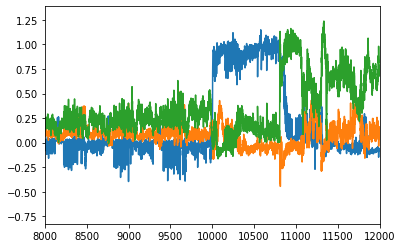

In [28]:
plt.plot(outputs[:, 0, :])
plt.xlim(8000, 12000)

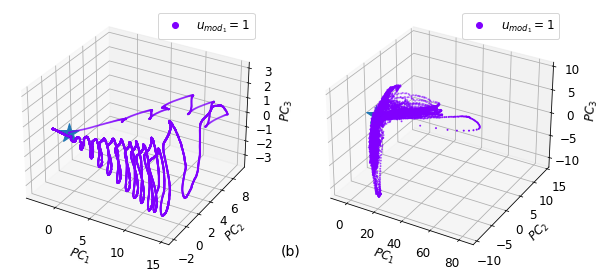

In [26]:
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in dm_task_values]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors[:], cmap="rainbow"
)
plt.legend(handles=scatter.legend_elements()[0], labels=sp_names, ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

# plt.tight_layout()
ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors[:], cmap="rainbow"
)
plt.legend(handles=scatter.legend_elements()[0], labels=sp_names, ncol=2)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
# ax.plot(pca_v[-20000, 0], pca_v[-20000, 1], pca_v[-20000, 2], '*', markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)
# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaDmSingleLongAfterRomo.eps')
plt.show()
# plt.close()

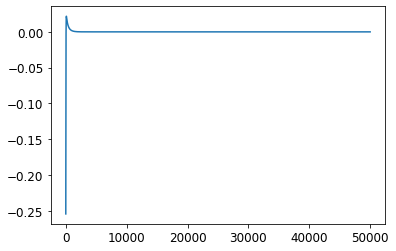

In [38]:
plt.plot(pca_a[:, 1])

In [14]:
from norse.torch import LIFAdExState

dm_task_1_sequence = []
dm_task_values = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]

for value in dm_task_values:
    dm_parameters = DMTaskRandomModParameters(
        dm=DMTaskParameters(
            trial_time=1.1, positive_shift_trial_time=0, answer_time=0.25, value=value
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    dm_task_1_sequence.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("DMTask2"),
            mode="value",
        )
    )
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)
pca_v, pca_a, task_times = single_task_pca_generate(
    dm_task_1_sequence, model, added_iterations=0, init_state=init_state, task_time=True
)

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)
sp_names = dm_task_values

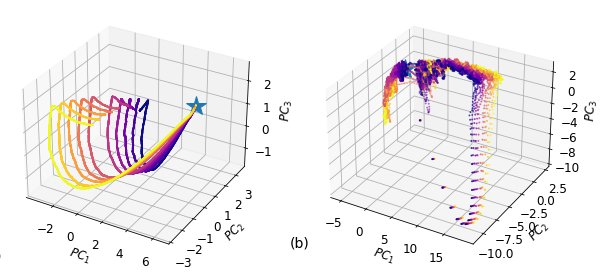

In [15]:
%matplotlib inline
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in dm_task_values]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="plasma"
)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
# ax.plot(pca_a[-20000, 0], pca_a[-20000, 1], pca_a[-20000, 2], '*', markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

# plt.tight_layout()
ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="plasma"
)

ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
# ax.plot(pca_v[-20000, 0], pca_v[-20000, 1], pca_v[-20000, 2], '*', markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)
# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaDmSingleLongAfter.eps')
plt.show()
# plt.close()

In [16]:
np.save("dm/colors_pca_dm", colors)
np.save("dm/pca_a_dm", pca_a.numpy())
np.save("dm/pca_v_dm", pca_v.numpy())
np.save("dm/dm_values", dm_task_values)

In [40]:
np.save("pca_a_dm", pca_a.numpy())
np.save("pca_v_dm", pca_v.numpy())

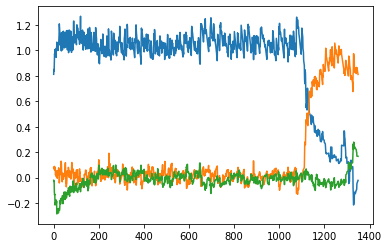

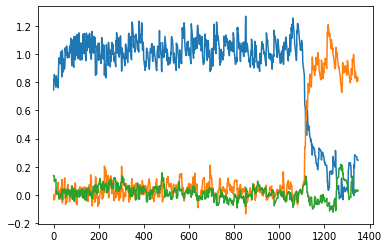

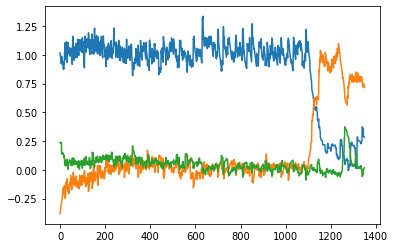

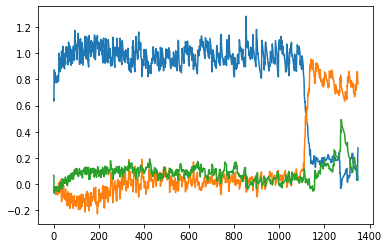

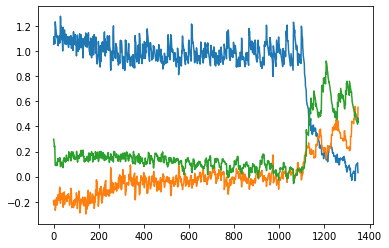

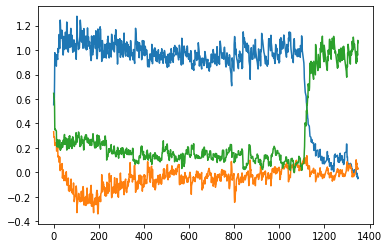

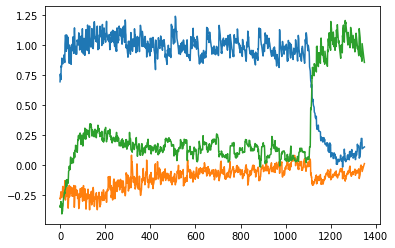

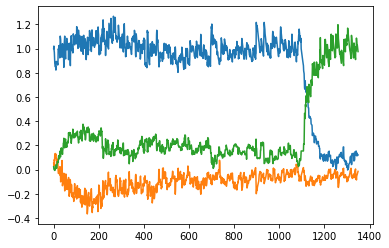

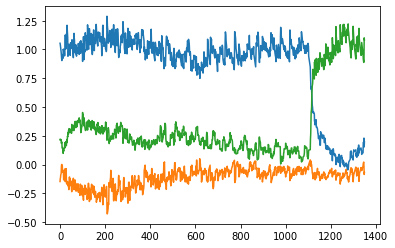

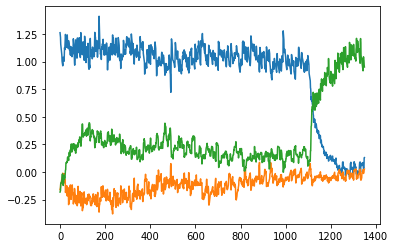

In [17]:
%matplotlib inline
data = None
for i in range(len(dm_task_1_sequence)):
    inputs, t_out = dm_task_1_sequence[i].dataset(1)
    # inputs = np.concatenate((inputs, np.zeros((50000, inputs.shape[1], inputs.shape[2]))), axis=0)
    # data = np.concatenate((np.zeros((1000, data.shape[1], data.shape[2])), data))
    # if data is None:
    # data = np.copy(inputs)
    # else:
    # data = np.concatenate((data, inputs))
    init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device) * 1,
        torch.zeros(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )
    data = inputs
    data = torch.from_numpy(data).type(torch.float).to(device)
    out, _ = model(data, init_state)
    out = out.detach().cpu().numpy()
    plt.plot(out[:, 0, :])
    plt.show()
# plt.close()

In [35]:
len(dm_task_1_sequence)

2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


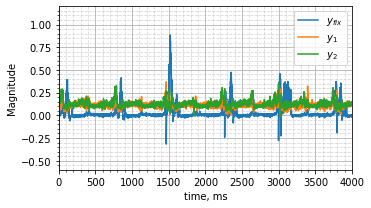

In [38]:
% matplotlib inline
plt.figure(figsize=(5, 3))
for j in range(3):
    plt.plot(out[-13000:-9000, 0, j], label=r"$y_{fix}$" if j == 0 else rf"$y_{j}$")
plt.legend()
plt.xlabel("time, ms")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.minorticks_on()
plt.xlim(0, 4000)
plt.ylim(-0.6, 1.2)
plt.grid(True)
plt.grid(which="minor", alpha=0.5, linestyle="--")
plt.savefig("LongOutAndTask.eps")
plt.show()

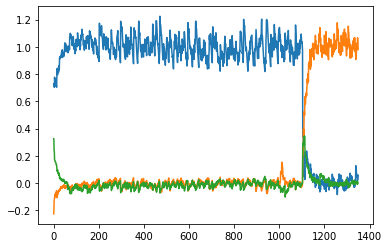

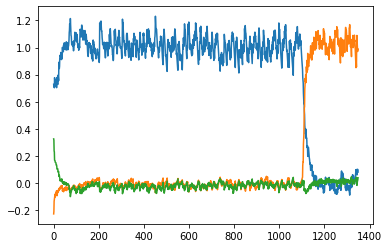

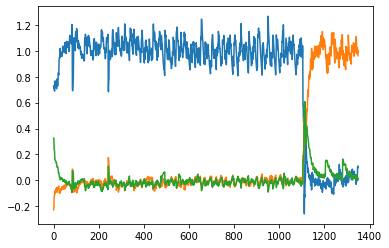

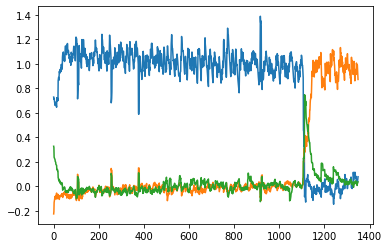

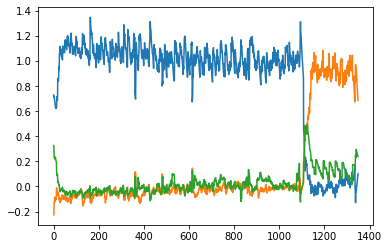

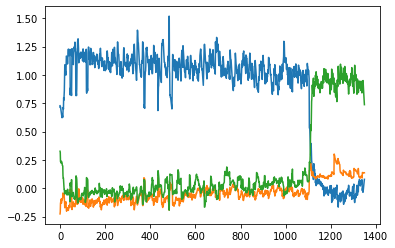

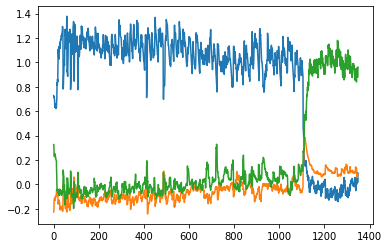

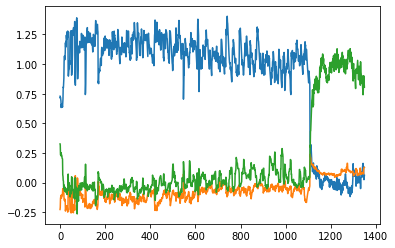

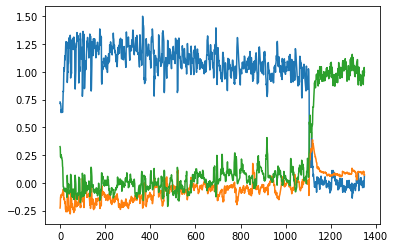

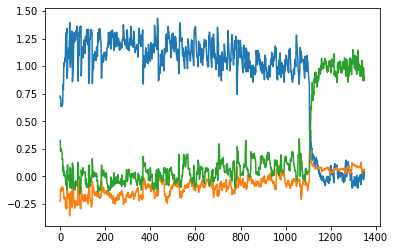

In [25]:
%matplotlib inline
for i in range(len(dm_task_1_sequence)):
    data, t_out = dm_task_1_sequence[i].dataset()
    data = torch.from_numpy(data).type(torch.float).to(device)
    out, _ = model(data, init_state)
    out = out.detach().cpu().numpy()
    plt.plot(out[:, 0, :])
    plt.show()
    plt.close()

a:\src\multy_task\env\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


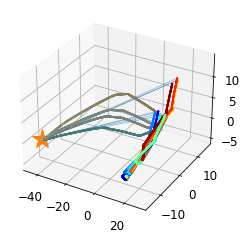

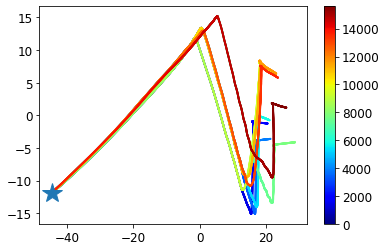

a:\src\multy_task\env\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


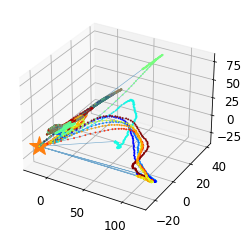

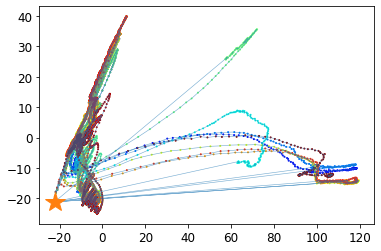

In [29]:
dm_task_2_sequence = []
dm_task_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
for value in dm_task_values:
    dm_parameters = DMTaskRandomModParameters(
        dm=DMTaskParameters(
            trial_time=0.1, positive_shift_trial_time=1.5, answer_time=0.25, value=value
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    dm_task_2_sequence.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("DMTask2"),
            mode="value",
        )
    )
colors = [*range(len(pca_a))]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="jet")
ax.plot(pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], linewidth=0.6, alpha=0.6)
# plt.plot(pca_v[:600, 0], pca_v[:600, 1], linewidth=6.6)
# plt.plot(pca_v[600:750, 0], pca_v[600:750, 1], linewidth=6.6)

ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
plt.show()
plt.close()

colors = [*range(len(pca_v))]
plt.scatter(pca_a[:, 0], pca_a[:, 1], s=1, c=colors, cmap="jet")
plt.plot(pca_a[0, 0], pca_a[0, 1], "*", markersize=20)
plt.colorbar()
plt.show()
plt.close()

colors = [*range(len(pca_v))]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="jet")
ax.plot(pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], linewidth=0.6, alpha=0.6)
# plt.plot(pca_v[:600, 0], pca_v[:600, 1], linewidth=6.6)
# plt.plot(pca_v[600:750, 0], pca_v[600:750, 1], linewidth=6.6)

ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
# plt.ylim([-25, -10])
plt.show()
plt.close()

plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, c=colors, cmap="jet")
plt.plot(pca_v[:, 0], pca_v[:, 1], linewidth=0.6, alpha=0.6)
# plt.plot(pca_v[:600, 0], pca_v[:600, 1], linewidth=6.6)
# plt.plot(pca_v[600:750, 0], pca_v[600:750, 1], linewidth=6.6)

plt.plot(pca_v[0, 0], pca_v[0, 1], "*", markersize=20)
# plt.ylim([-25, -10])
plt.show()
plt.close()

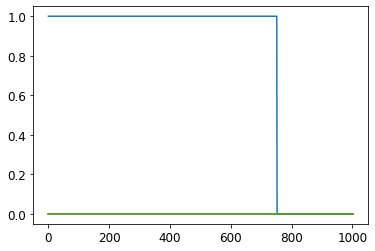

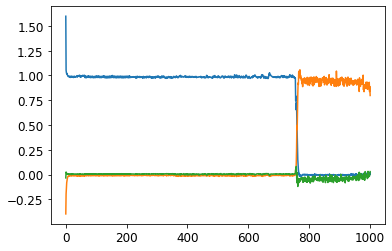

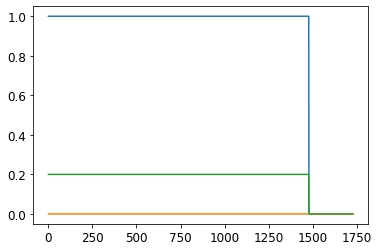

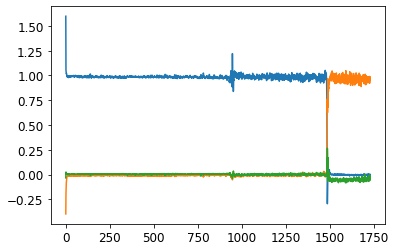

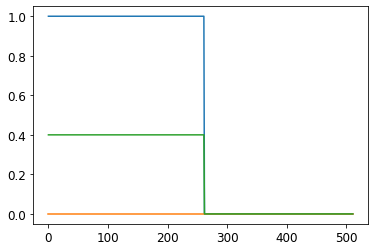

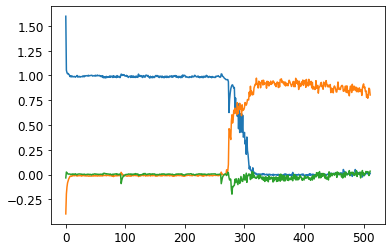

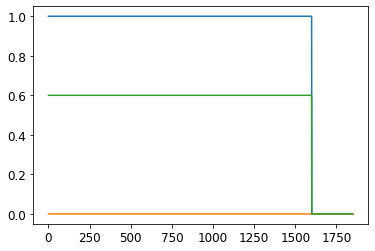

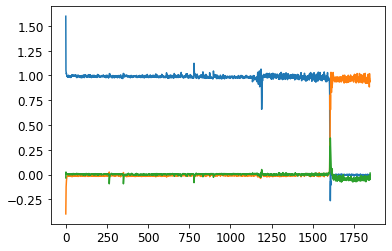

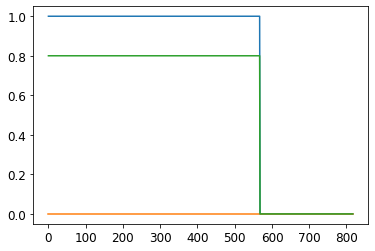

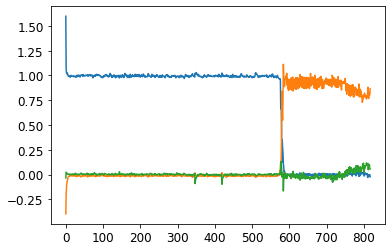

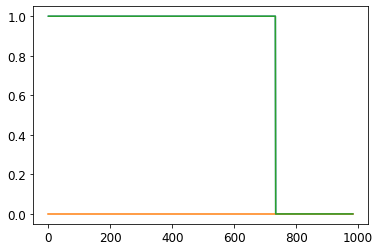

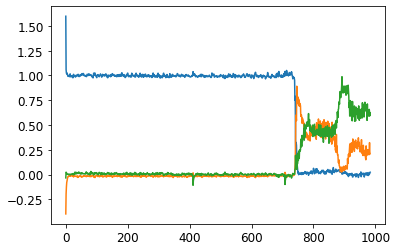

In [30]:
for i in range(len(dm_task_2_sequence)):
    data, t_out = dm_task_2_sequence[i].dataset(delay_between=0)
    plt.plot(data[:, 0, :3])
    plt.show()
    plt.close()
    data = torch.from_numpy(data).type(torch.float).to(device)

    out, _ = model(data, init_state)
    out = out.detach().cpu().numpy()
    plt.plot(out[:, 0, :])
    plt.show()
    plt.close()

In [18]:
task_pca_list = []
task_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
task_values = [0, 0.1, 0.9, 1]
for value in task_values:
    romo_parameters = RomoTaskRandomModParameters(
        romo=RomoTaskParameters(
            delay=1,
            positive_shift_delay_time=0.0,
            trial_time=0.3,
            positive_shift_trial_time=0.0,
            value=(0.3, value),
            answer_time=0.25,
        ),
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("RomoTask1"),
            mode="value",
        )
    )

for value in task_values:
    romo_parameters = RomoTaskRandomModParameters(
        romo=RomoTaskParameters(
            delay=1,
            positive_shift_delay_time=0.0,
            trial_time=0.3,
            positive_shift_trial_time=0.0,
            value=(0.7, value),
            answer_time=0.25,
        ),
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("RomoTask1"),
            mode="value",
        )
    )

pca_v, pca_a, task_times = single_task_pca_generate(
    task_pca_list, model, added_iterations=0, task_time=True
)
colors = [*range(len(pca_a))]

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)

In [20]:

from matplotlib.pyplot import cm
%matplotlib
plt.rcParams.update({'font.size': 12})
second_index_names = [r'$u_{mod_1} = $' + f'{el}' for el in task_values]
first_index = [0.3, 0.7]
first_index_name = [r'$u_{mod_1} = $' + f'{el}' for el in first_index]

sp_names = [first_index_name[0] + '; ' + el for el in second_index_names] + [first_index_name[1] + '; ' + el for el in
                                                                             second_index_names]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap='rainbow')
#plt.legend(handles=scatter.legend_elements()[0],
#           labels=sp_names,
#           ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], '*', markersize=20)
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
ax.set_zlabel('$PC_3$')
ax.text(-0.05, -0.1, -0.1, '(a)', transform=ax.transAxes,
        fontsize=14, va='bottom', ha='right')
ax.view_init(45, 45)
last_time = []
colors=np.array(colors)
color = cm.rainbow(np.linspace(0, 1, colors[-1] + 1))
for i in range(colors[-1] + 1):
    last_time.append(np.where(colors == i)[0][-1])
for point in last_time:
    plt.plot(
        pca_a[point, 0],
        pca_a[point, 1],
        pca_a[point, 2],
        "*",
        markersize=10,
        c=color[i],
)
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap='rainbow')
plt.legend(handles=scatter.legend_elements()[0],
           labels=sp_names,
           ncol=3, loc='upper center', bbox_to_anchor=(0.0, 1.25), shadow=True)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], '*', markersize=20)
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
ax.set_zlabel('$PC_3$')
ax.text(-0.05, -0.1, -0.1, '(b)', transform=ax.transAxes,
        fontsize=14, va='bottom', ha='right')

for point in last_time:
    plt.plot(
        pca_v[point, 0],
        pca_v[point, 1],
        pca_v[point, 2],
        "*",
        markersize=10,
        c=color[i],
)


#plt.colorbar(scatter, ax=ax, orientation="vertical")
#plt.tight_layout()
#plt.savefig('pca_a.pdf')
plt.show()


Using matplotlib backend: TkAgg


In [40]:
np.linspace(0, 1, colors[-1] + 1), colors[-1] + 1

(array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
        0.71428571, 0.85714286, 1.        ]),
 8)

In [21]:
np.save("romo/colors_pca_romo", colors)
np.save("romo/pca_a_romo", pca_a.numpy())
np.save("romo/pca_v_romo", pca_v.numpy())
np.save("romo/romo_values", dm_task_values)

np.save("romo/romo_sp_names", sp_names)

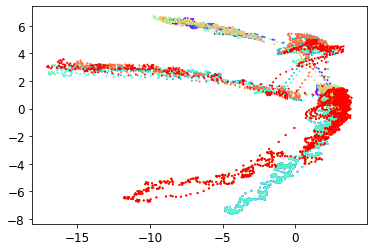

In [57]:
plt.scatter(pca_v[:, 0], pca_v[:, 1], c=colors, cmap="rainbow", s=1)

In [ ]:
import pandas as pd

df2 = pd.DataFrame(
    {
        "PC1": pca_a[:, 0].numpy(),
        "PC2": pca_a[:, 1].numpy(),
        "PC3": pca_a[:, 2].numpy(),
        "D": np.array(colors),
        "size": np.array([0.1] * len(pca_a)),
    }
)
import plotly.express as px

#!pip install -U kaleido
fig = px.scatter_3d(df2, x="PC1", y="PC2", z="PC3", color="D", size="size")
fig.update_layout(height=800, title_text="GDP and Life Expectancy (Americas, 2007)")
fig.update_traces(marker_size=1)
fig.write_image("DmPcaA.svg")
fig.show()

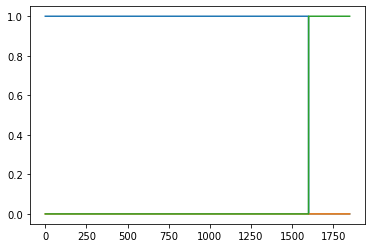

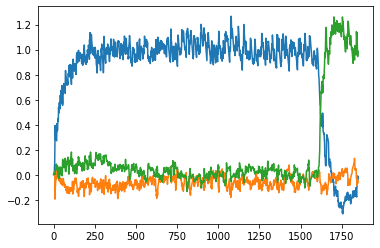

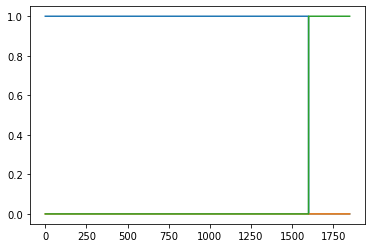

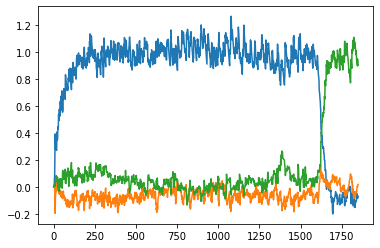

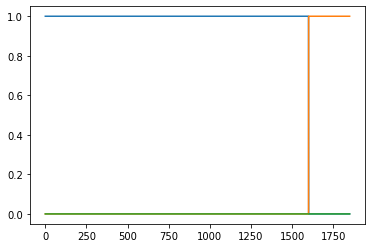

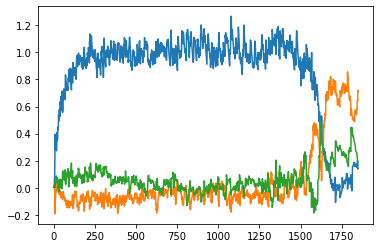

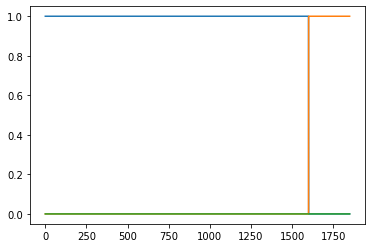

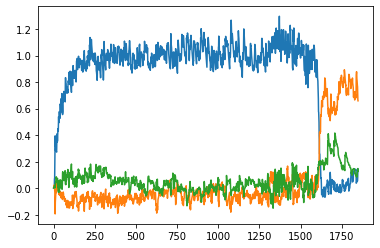

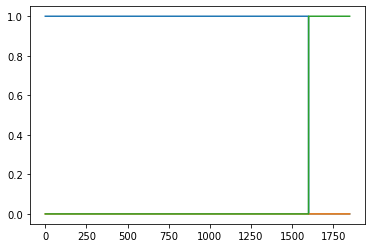

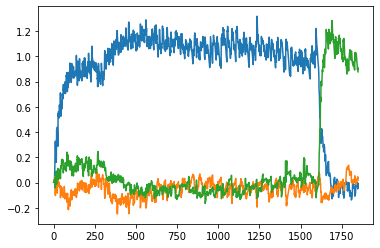

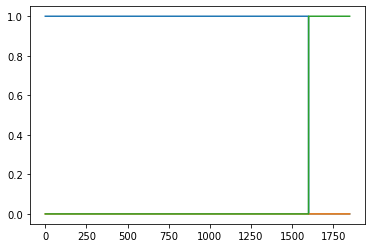

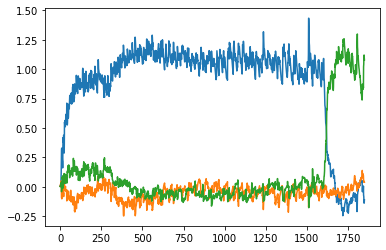

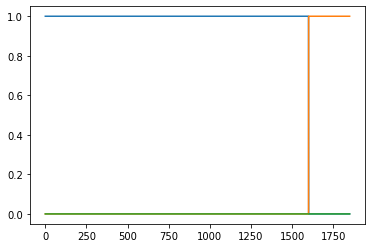

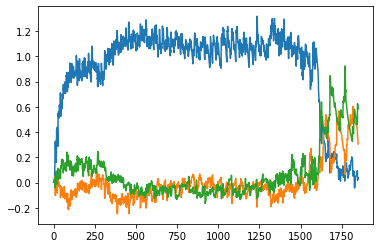

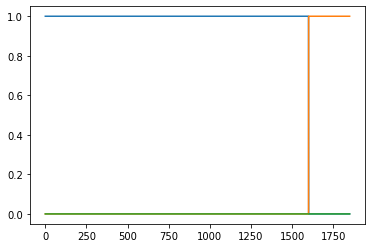

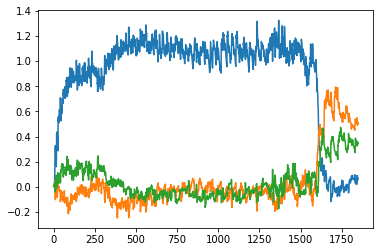

In [28]:
%matplotlib inline
for i in range(len(task_pca_list)):
    data, t_out = task_pca_list[i].dataset()
    plt.plot(t_out[:, 0, :])
    plt.show()
    plt.close()
    data = torch.from_numpy(data).type(torch.float).to(device)

    out, _ = model(data)
    out = out.detach().cpu().numpy()

    plt.plot(out[:, 0, :])
    plt.show()
    plt.close()

a:\src\multy_task\env\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


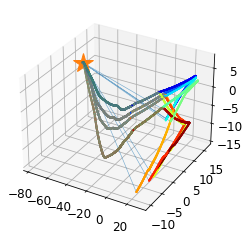

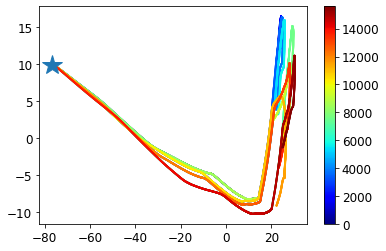

a:\src\multy_task\env\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


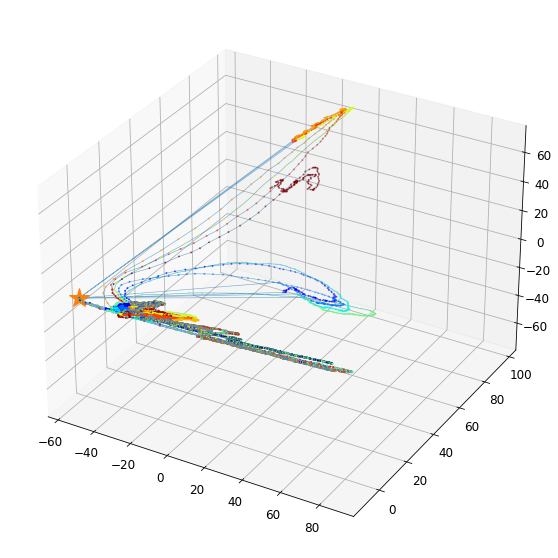

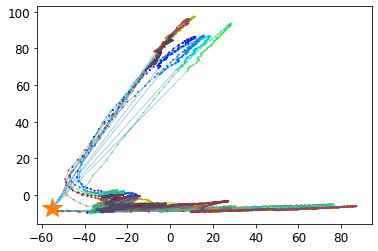

In [92]:
task_pca_list = []
task_values = [0, 0.4, 0.6, 1]
for value in task_values:
    romo_parameters = RomoTaskRandomModParameters(
        romo=RomoTaskParameters(
            delay=0.8,
            positive_shift_delay_time=0.0,
            trial_time=0.5,
            positive_shift_trial_time=0.0,
            value=(value, 0.2),
        ),
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("RomoTask1"),
            mode="value",
        )
    )

for value in task_values:
    romo_parameters = RomoTaskRandomModParameters(
        romo=RomoTaskParameters(
            delay=0.8,
            positive_shift_delay_time=0.0,
            trial_time=0.5,
            positive_shift_trial_time=0.0,
            value=(value, 0.8),
        ),
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("RomoTask1"),
            mode="value",
        )
    )
pca_v, pca_a = single_task_pca_generate(task_pca_list, model, added_iterations=0)
colors = [*range(len(pca_a))]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="jet")
ax.plot(pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], linewidth=0.6, alpha=0.6)
# plt.plot(pca_v[:600, 0], pca_v[:600, 1], linewidth=6.6)
# plt.plot(pca_v[600:750, 0], pca_v[600:750, 1], linewidth=6.6)

ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
plt.show()
plt.close()

colors = [*range(len(pca_v))]
plt.scatter(pca_a[:, 0], pca_a[:, 1], s=1, c=colors, cmap="jet")
plt.plot(pca_a[0, 0], pca_a[0, 1], "*", markersize=20)
plt.colorbar()
plt.show()
plt.close()

colors = [*range(len(pca_v))]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="jet")
ax.plot(pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], linewidth=0.6, alpha=0.6)
# plt.plot(pca_v[:600, 0], pca_v[:600, 1], linewidth=6.6)
# plt.plot(pca_v[600:750, 0], pca_v[600:750, 1], linewidth=6.6)

ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
# plt.ylim([-25, -10])
plt.show()
plt.close()

plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, c=colors, cmap="jet")
plt.plot(pca_v[:, 0], pca_v[:, 1], linewidth=0.6, alpha=0.6)
# plt.plot(pca_v[:600, 0], pca_v[:600, 1], linewidth=6.6)
# plt.plot(pca_v[600:750, 0], pca_v[600:750, 1], linewidth=6.6)

plt.plot(pca_v[0, 0], pca_v[0, 1], "*", markersize=20)
# plt.ylim([-25, -10])
plt.show()
plt.close()

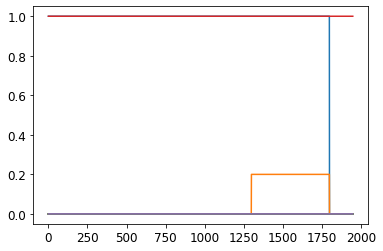

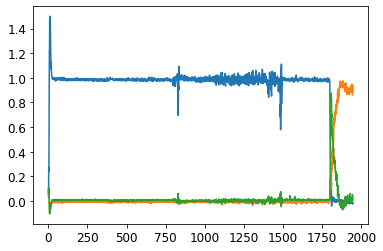

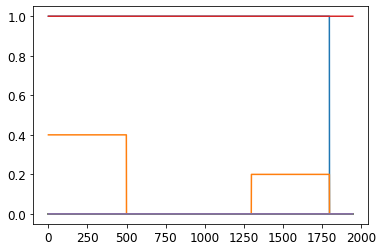

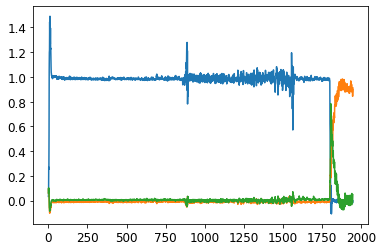

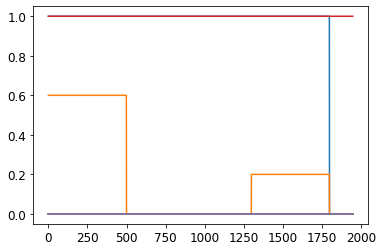

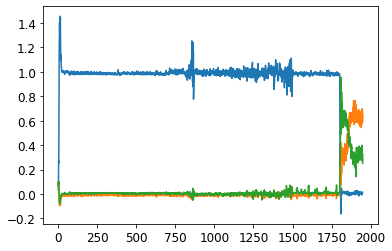

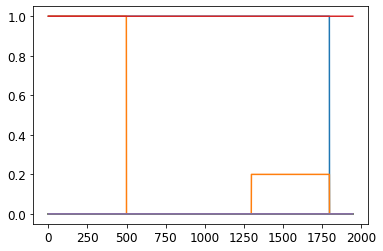

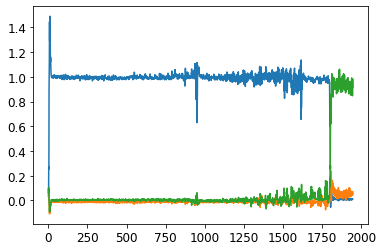

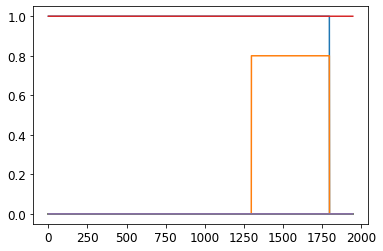

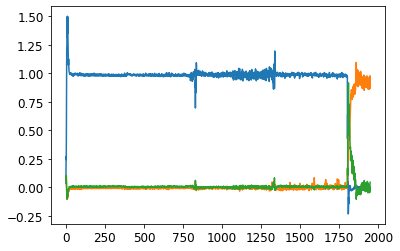

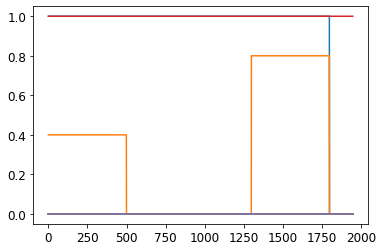

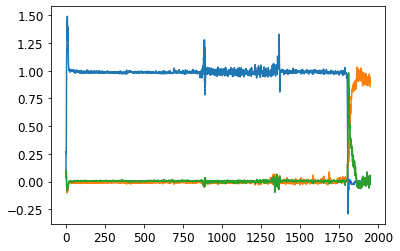

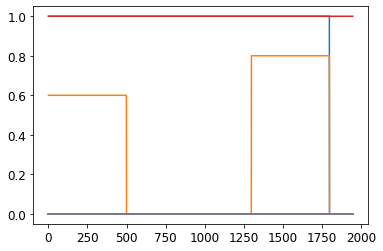

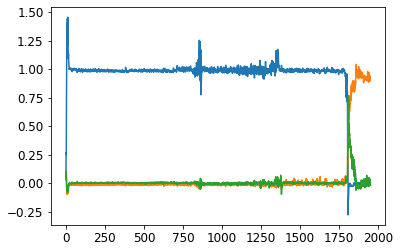

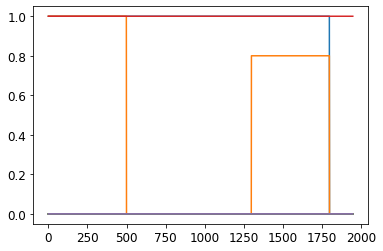

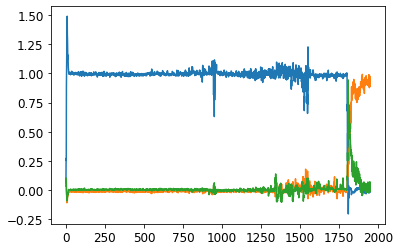

In [28]:
for i in range(len(task_pca_list)):
    data, t_out = task_pca_list[i].dataset(1)
    plt.plot(data[:, 0, :])
    plt.show()
    plt.close()
    data = torch.from_numpy(data).type(torch.float).to(device)

    out, _ = model(data)
    out = out.detach().cpu().numpy()
    plt.plot(out[:, 0, :])
    plt.show()
    plt.close()

In [105]:
from norse.torch import LIFAdExState

task_pca_list = []
task_values = go_task_list_values[::2]  # [np.array([0, 3, 6, 7])]

for value in task_values:
    go_parameters = GoTaskRandomModParameters(
        go=GoTaskParameters(
            trial_time=0.8,
            positive_shift_trial_time=0,
            # value=0.8,
            value=value,
            answer_time=0.50,
        )
    )
    gort_parameters = GoRtTaskRandomModParameters(
        go_rt=GoRtTaskParameters(
            trial_time=0.8, positive_shift_trial_time=0.0, value=value, answer_time=1.5
        )
    )
    godl_parameters = GoDlTaskRandomModParameters(
        go_dl=GoDlTaskParameters(
            go=GoTaskParameters(
                trial_time=0.8,
                positive_shift_trial_time=0.2,
                value=value,
                answer_time=0.25,
            ),
            delay=0.8,
            positive_shift_delay_time=0,
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("GoTask1"),
            mode="value",
        )
    )
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)

pca_v, pca_a, task_times = single_task_pca_generate(
    task_pca_list, model, added_iterations=0, task_time=True
)
colors = [*range(len(pca_a))]

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)

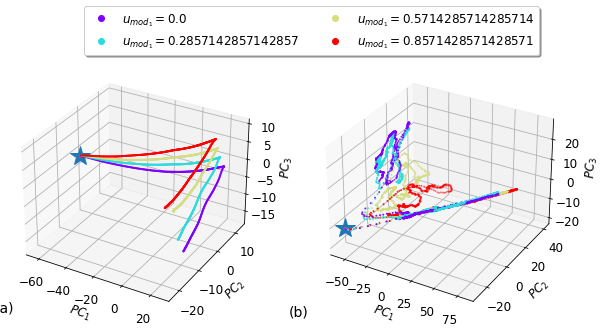

In [106]:
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in task_values]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="rainbow"
)
# plt.legend(handles=scatter.legend_elements()[0],
#           labels=sp_names,
#           ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="rainbow"
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=sp_names,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.0, 1.25),
    shadow=True,
)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaGoRtSingle.eps')
plt.show()
plt.close()

In [107]:
np.save("colors_pca_go", colors)
np.save("pca_a_go", pca_a.numpy())
np.save("pca_v_go", pca_v.numpy())
np.save("go_values", dm_task_values)

np.save("go_sp_names", sp_names)

In [109]:
from norse.torch import LIFAdExState

task_pca_list = []
task_values = go_task_list_values[::2]  # [np.array([0, 3, 6, 7])]

for value in task_values:
    go_parameters = GoTaskRandomModParameters(
        go=GoTaskParameters(
            trial_time=0.8,
            positive_shift_trial_time=0,
            # value=0.8,
            value=value,
            answer_time=0.50,
        )
    )
    gort_parameters = GoRtTaskRandomModParameters(
        go_rt=GoRtTaskParameters(
            trial_time=0.8, positive_shift_trial_time=0.0, value=value, answer_time=1.5
        )
    )
    godl_parameters = GoDlTaskRandomModParameters(
        go_dl=GoDlTaskParameters(
            go=GoTaskParameters(
                trial_time=0.8,
                positive_shift_trial_time=0.2,
                value=value,
                answer_time=0.25,
            ),
            delay=0.8,
            positive_shift_delay_time=0,
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("GoRtTask1"),
            mode="value",
        )
    )
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)

pca_v, pca_a, task_times = single_task_pca_generate(
    task_pca_list, model, added_iterations=0, task_time=True
)
colors = [*range(len(pca_a))]

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)

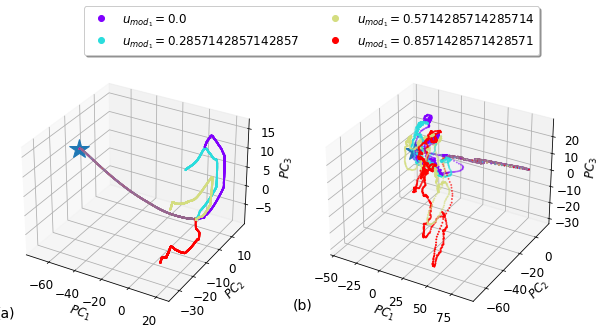

In [110]:
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in task_values]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="rainbow"
)
# plt.legend(handles=scatter.legend_elements()[0],
#           labels=sp_names,
#           ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="rainbow"
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=sp_names,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.0, 1.25),
    shadow=True,
)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaGoRtSingle.eps')
plt.show()
plt.close()

In [111]:
np.save("colors_pca_gort", colors)
np.save("pca_a_gort", pca_a.numpy())
np.save("pca_v_gort", pca_v.numpy())
np.save("gort_values", dm_task_values)

np.save("gort_sp_names", sp_names)

In [25]:
%matplotlib inline

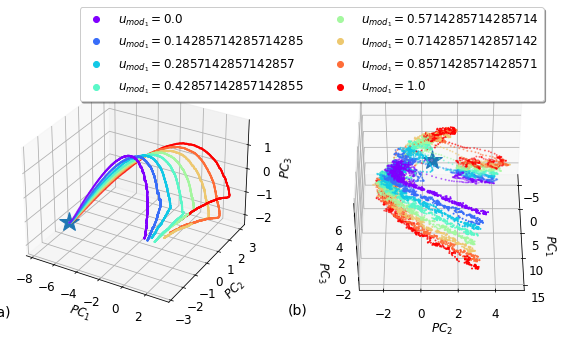

In [26]:
from norse.torch import LIFAdExState

task_pca_list = []
task_values = go_task_list_values[::1]  # [np.array([0, 3, 6, 7])]

for value in task_values:
    go_parameters = GoTaskRandomModParameters(
        go=GoTaskParameters(
            trial_time=0.8,
            positive_shift_trial_time=0,
            # value=0.8,
            value=value,
            answer_time=0.50,
        )
    )
    gort_parameters = GoRtTaskRandomModParameters(
        go_rt=GoRtTaskParameters(
            trial_time=0.8, positive_shift_trial_time=0.0, value=value, answer_time=1.5
        )
    )
    godl_parameters = GoDlTaskRandomModParameters(
        go_dl=GoDlTaskParameters(
            go=GoTaskParameters(
                trial_time=0.8,
                positive_shift_trial_time=0.2,
                value=value,
                answer_time=0.25,
            ),
            delay=0.2,
            positive_shift_delay_time=0,
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("GoDlTask1"),
            mode="value",
        )
    )
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)

pca_v, pca_a, task_times = single_task_pca_generate(
    task_pca_list, model, added_iterations=0, task_time=True
)
colors = [*range(len(pca_a))]

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in task_values]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="rainbow"
)
# plt.legend(handles=scatter.legend_elements()[0],
#           labels=sp_names,
#           ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="rainbow"
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=sp_names,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.0, 1.25),
    shadow=True,
)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)
ax.view_init(45, 0)
# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaGoRtSingle.eps')
plt.show()
plt.close()
np.save("go_dl/colors_pca_godl", colors)
np.save("go_dl/pca_a_godl", pca_a.numpy())
np.save("go_dl/pca_v_godl", pca_v.numpy())
np.save("go_dl/godl_values", dm_task_values)

np.save("go_dl/godl_sp_names", sp_names)

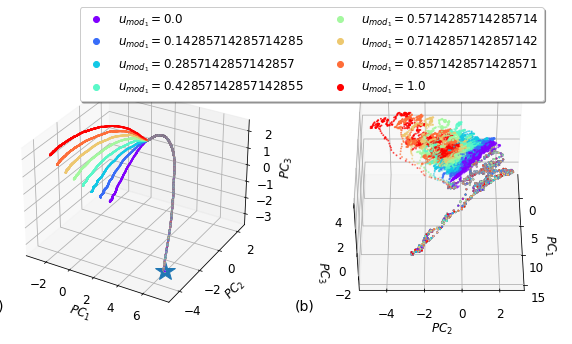

In [28]:
from norse.torch import LIFAdExState

task_pca_list = []
task_values = go_task_list_values[::1]  # [np.array([0, 3, 6, 7])]

for value in task_values:
    go_parameters = GoTaskRandomModParameters(
        go=GoTaskParameters(
            trial_time=0.8,
            positive_shift_trial_time=0,
            # value=0.8,
            value=value,
            answer_time=0.50,
        )
    )
    gort_parameters = GoRtTaskRandomModParameters(
        go_rt=GoRtTaskParameters(
            trial_time=0.8, positive_shift_trial_time=0.0, value=value, answer_time=1.5
        )
    )
    godl_parameters = GoDlTaskRandomModParameters(
        go_dl=GoDlTaskParameters(
            go=GoTaskParameters(
                trial_time=0.8,
                positive_shift_trial_time=0.2,
                value=value,
                answer_time=0.25,
            ),
            delay=0.2,
            positive_shift_delay_time=0,
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("GoRtTask1"),
            mode="value",
        )
    )
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)

pca_v, pca_a, task_times = single_task_pca_generate(
    task_pca_list, model, added_iterations=0, task_time=True
)
colors = [*range(len(pca_a))]

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in task_values]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="rainbow"
)
# plt.legend(handles=scatter.legend_elements()[0],
#           labels=sp_names,
#           ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="rainbow"
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=sp_names,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.0, 1.25),
    shadow=True,
)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)
ax.view_init(45, 0)
# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaGoRtSingle.eps')
plt.show()
plt.close()
np.save("go_rt/colors_pca_gort", colors)
np.save("go_rt/pca_a_gort", pca_a.numpy())
np.save("go_rt/pca_v_gort", pca_v.numpy())
np.save("go_rt/gort_values", dm_task_values)

np.save("go_rt/gort_sp_names", sp_names)

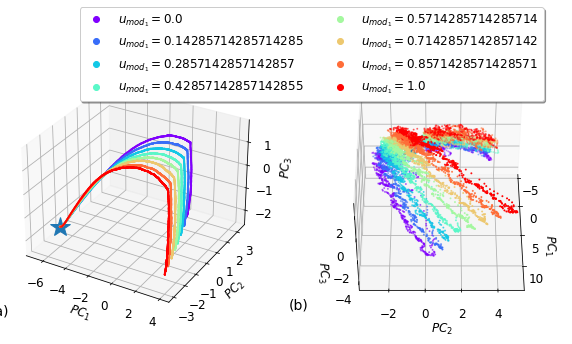

In [27]:
from norse.torch import LIFAdExState

task_pca_list = []
task_values = go_task_list_values[::1]  # [np.array([0, 3, 6, 7])]

for value in task_values:
    go_parameters = GoTaskRandomModParameters(
        go=GoTaskParameters(
            trial_time=0.8,
            positive_shift_trial_time=0,
            # value=0.8,
            value=value,
            answer_time=0.50,
        )
    )
    gort_parameters = GoRtTaskRandomModParameters(
        go_rt=GoRtTaskParameters(
            trial_time=0.8, positive_shift_trial_time=0.0, value=value, answer_time=1.5
        )
    )
    godl_parameters = GoDlTaskRandomModParameters(
        go_dl=GoDlTaskParameters(
            go=GoTaskParameters(
                trial_time=0.8,
                positive_shift_trial_time=0.2,
                value=value,
                answer_time=0.25,
            ),
            delay=0.2,
            positive_shift_delay_time=0,
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("GoTask1"),
            mode="value",
        )
    )
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)

pca_v, pca_a, task_times = single_task_pca_generate(
    task_pca_list, model, added_iterations=0, task_time=True
)
colors = [*range(len(pca_a))]

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in task_values]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="rainbow"
)
# plt.legend(handles=scatter.legend_elements()[0],
#           labels=sp_names,
#           ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="rainbow"
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=sp_names,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.0, 1.25),
    shadow=True,
)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)
ax.view_init(45, 0)
# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaGoRtSingle.eps')
plt.show()
plt.close()
np.save("go/colors_pca_go", colors)
np.save("go/pca_a_go", pca_a.numpy())
np.save("go/pca_v_go", pca_v.numpy())
np.save("go/go_values", dm_task_values)

np.save("go/go_sp_names", sp_names)

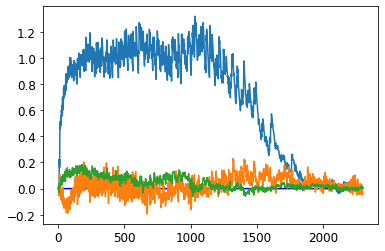

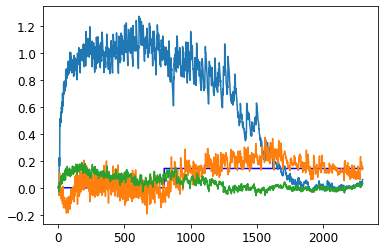

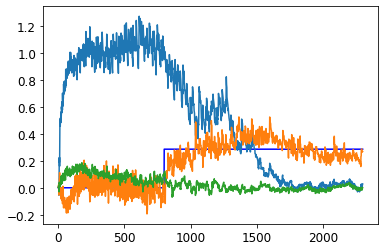

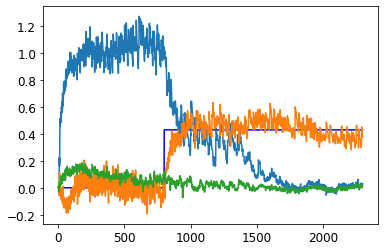

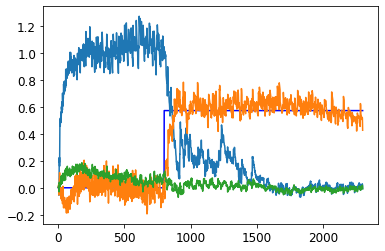

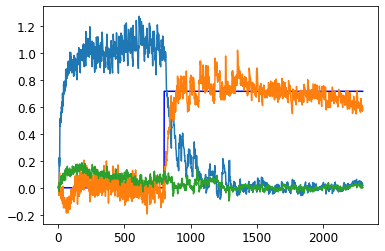

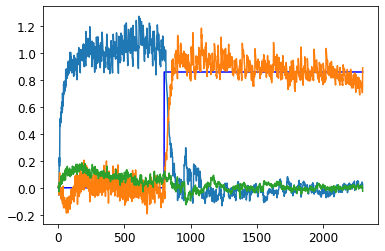

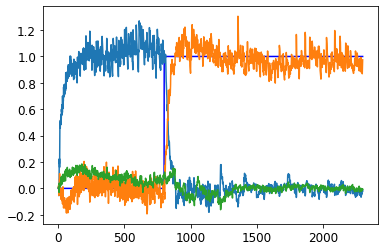

In [29]:
for i in range(len(task_pca_list)):
    data, t_out = task_pca_list[i].dataset()
    # data[:, :, 1:3] += every_bath_generator(.1, .1, data.shape[0], data.shape[1], 2)
    plt.plot(t_out[:, 0, 1], c="b")
    # plt.show()
    # plt.close()
    data = torch.from_numpy(data).type(torch.float).to(device)

    out, _ = model(data)
    out = out.detach().cpu().numpy()
    plt.plot(out[:, 0, :])
    plt.show()
    plt.close()

In [49]:
from norse.torch import LIFAdExState

task_pca_list = []
task_values = go_task_list_values  # [np.array([0, 3, 6, 7])]

for value in task_values:
    go_parameters = GoTaskRandomModParameters(
        go=GoTaskParameters(
            trial_time=0.8,
            positive_shift_trial_time=0,
            # value=0.8,
            value=value,
            answer_time=0.50,
        )
    )
    gort_parameters = GoRtTaskRandomModParameters(
        go_rt=GoRtTaskParameters(
            trial_time=0.8, positive_shift_trial_time=0.0, value=value, answer_time=1.5
        )
    )
    godl_parameters = GoDlTaskRandomModParameters(
        go_dl=GoDlTaskParameters(
            go=GoTaskParameters(
                trial_time=0.8,
                positive_shift_trial_time=0.2,
                value=value,
                answer_time=0.25,
            ),
            delay=0.8,
            positive_shift_delay_time=0,
        )
    )
    task_dict = {
        tasks[0]: romo_parameters,
        tasks[1]: romo_parameters,
        tasks[2]: dm_parameters,
        tasks[3]: dm_parameters,
        tasks[4]: ctx_parameters,
        tasks[5]: ctx_parameters,
        tasks[6]: go_parameters,
        tasks[7]: go_parameters,
        tasks[8]: gort_parameters,
        tasks[9]: gort_parameters,
        tasks[10]: godl_parameters,
        tasks[11]: godl_parameters,
    }

    task_pca_list.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=sorted(tasks).index("GoTask1"),
            mode="value",
        )
    )
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)

pca_v, pca_a, task_times = single_task_pca_generate(
    task_pca_list, model, added_iterations=0, task_time=True
)
colors = [*range(len(pca_a))]

colors = []
for el in [[i] * task_times[i] for i in range(len(task_times))]:
    colors.extend(el)

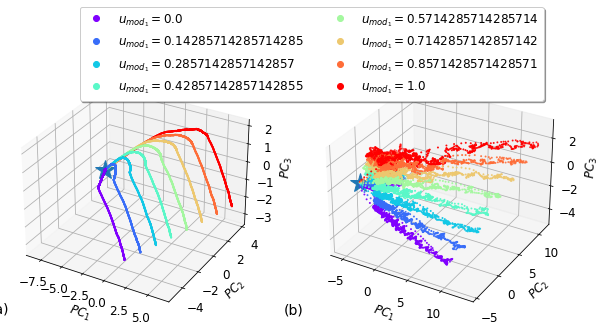

In [50]:
plt.rcParams.update({"font.size": 12})
sp_names = [r"$u_{mod_1} = $" + f"{el}" for el in task_values]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection="3d")
scatter = ax.scatter(
    pca_a[:, 0], pca_a[:, 1], pca_a[:, 2], s=1, c=colors, cmap="rainbow"
)
# plt.legend(handles=scatter.legend_elements()[0],
#           labels=sp_names,
#           ncol=2)
ax.plot(pca_a[0, 0], pca_a[0, 1], pca_a[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(a)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

ax = fig.add_subplot(122, projection="3d")
scatter = ax.scatter(
    pca_v[:, 0], pca_v[:, 1], pca_v[:, 2], s=1, c=colors, cmap="rainbow"
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=sp_names,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.0, 1.25),
    shadow=True,
)
ax.plot(pca_v[0, 0], pca_v[0, 1], pca_v[0, 2], "*", markersize=20)
ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax.text(
    -0.05,
    -0.1,
    -0.1,
    "(b)",
    transform=ax.transAxes,
    fontsize=14,
    va="bottom",
    ha="right",
)

# plt.colorbar(scatter, ax=ax, orientation="vertical")
# plt.tight_layout()
# plt.savefig('pca_a.pdf')
# plt.savefig('PcaGoRtSingle.eps')
plt.show()
plt.close()

In [95]:
np.save("colors_pca_go", colors)
np.save("pca_a_go", pca_a.numpy())
np.save("pca_v_go", pca_v.numpy())
np.save("go_values", dm_task_values)

np.save("go_sp_names", sp_names)

In [19]:
weights = {}
for name, param in model.named_parameters():
    weights[name] = param.detach().cpu().numpy()

In [20]:
w_rec = weights["alif.recurrent_weights"]
eigs = np.linalg.eig(w_rec)[0]

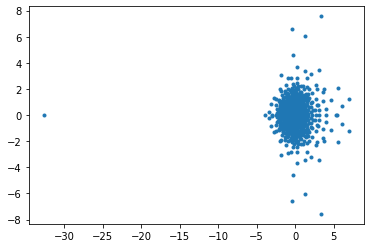

In [21]:
eigs_real = eigs.real
eigs_imag = eigs.imag
plt.plot(eigs_real, eigs_imag, ".")

In [34]:
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
    # return_spiking=False,
).to(device)

In [89]:
weights = {}
for name, param in model.named_parameters():
    weights[name] = param.detach().cpu().numpy()

w_rec = weights["alif.recurrent_weights"]
eigs_pre = np.linalg.eig(w_rec)[0]
eigs_real_pre = eigs_pre.real
eigs_imag_pre = eigs_pre.imag

In [94]:
% matplotlib
fig, ax = plt.subplots()
circle2 = plt.Circle((0, 0), 1, color="b", fill=False)
plt.plot(eigs_real, eigs_imag, ".", label="post")
plt.plot(eigs_real_pre, eigs_imag_pre, ".", label="pre")
plt.legend()
ax.add_patch(circle2)
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

Using matplotlib backend: TkAgg
